In [176]:
## caged_brach
%reload_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200

import basedosdados as bd

from geobr import read_municipality, read_state

import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.colors import ListedColormap

import plotly.express as px

In [150]:
query = """
WITH caged as (
  SELECT
    ano,
    CONCAT(ano,"-",id_municipio) as id_municipio,
    sigla_uf,
    admitidos_desligados,
    SUBSTR(cnae_2, 1, 2) as divisao_economica,
  FROM `basedosdados-dev.br_me_caged.microdados_antigos`
),

caged2 as (
  SELECT
    ano,
    id_municipio,
    sigla_uf,
    SAFE_CAST(divisao_economica as INT64) as divisao_economica,
    COUNTIF(admitidos_desligados = 1) as admitidos_total,
    COUNTIF(admitidos_desligados = 2) as desligados_total,
  FROM caged
  GROUP BY 1,2,3,4
  ORDER BY id_municipio, admitidos_total DESC
),

caged3 as (
  SELECT 
      ano,
      id_municipio,
      sigla_uf,
      divisao_economica as id_divisao_economica,
      CASE
          WHEN (divisao_economica>=1  AND divisao_economica<=3)  THEN "AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PESCA E AQÜICULTURA"
          WHEN (divisao_economica>=5  AND divisao_economica<=9)  THEN "INDÚSTRIAS EXTRATIVAS"
          WHEN (divisao_economica>=10 AND divisao_economica<=33) THEN "INDÚSTRIAS DE TRANSFORMAÇÃO"
          WHEN (divisao_economica>=35 AND divisao_economica<=35) THEN "ELETRICIDADE E GÁS"
          WHEN (divisao_economica>=36 AND divisao_economica<=39) THEN "ÁGUA, ESGOTO, ATIVIDADES DE GESTÃO DE RESÍDUOS E DESCONTAMINAÇÃO"
          WHEN (divisao_economica>=41 AND divisao_economica<=43) THEN "CONSTRUÇÃO"
          WHEN (divisao_economica>=45 AND divisao_economica<=47) THEN "COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E MOTOCICLETAS"
          WHEN (divisao_economica>=49 AND divisao_economica<=53) THEN "TRANSPORTE, ARMAZENAGEM E CORREIO"
          WHEN (divisao_economica>=55 AND divisao_economica<=56) THEN "ALOJAMENTO E ALIMENTAÇÃO"
          WHEN (divisao_economica>=58 AND divisao_economica<=63) THEN "INFORMAÇÃO E COMUNICAÇÃO"
          WHEN (divisao_economica>=64 AND divisao_economica<=66) THEN "ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS RELACIONADOS"
          WHEN (divisao_economica>=68 AND divisao_economica<=68) THEN "ATIVIDADES IMOBILIÁRIAS"
          WHEN (divisao_economica>=69 AND divisao_economica<=75) THEN "ATIVIDADES PROFISSIONAIS, CIENTÍFICAS E TÉCNICAS"
          WHEN (divisao_economica>=77 AND divisao_economica<=82) THEN "ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEMENTARES"
          WHEN (divisao_economica>=84 AND divisao_economica<=84) THEN "ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL"
          WHEN (divisao_economica>=85 AND divisao_economica<=85) THEN "EDUCAÇÃO"
          WHEN (divisao_economica>=86 AND divisao_economica<=88) THEN "SAÚDE HUMANA E SERVIÇOS SOCIAIS"
          WHEN (divisao_economica>=90 AND divisao_economica<=93) THEN "ARTES, CULTURA, ESPORTE E RECREAÇÃO"
          WHEN (divisao_economica>=94 AND divisao_economica<=96) THEN "OUTRAS ATIVIDADES DE SERVIÇOS"
          WHEN (divisao_economica>=97 AND divisao_economica<=97) THEN "SERVIÇOS DOMÉSTICOS"
          WHEN (divisao_economica>=99 AND divisao_economica<=99) THEN "ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUIÇÕES EXTRATERRITORIAIS"
      END AS divisao_economica,
      admitidos_total,
      desligados_total
  FROM caged2
),

caged4 as (
  SELECT event.* FROM (
    SELECT ARRAY_AGG(
      caged3 ORDER BY caged3.admitidos_total DESC LIMIT 1
    )[OFFSET(0)]  event
    FROM caged3 
    # GROUP BY the id you are de-duplicating by
    GROUP BY caged3.id_municipio 
  )
)


SELECT
  ano,
  SAFE_CAST(SUBSTR(id_municipio,6,11) AS INT64) as id_municipio,
  sigla_uf,
  divisao_economica,
  admitidos_total,
  desligados_total
FROM caged4
"""

caged = bd.read_sql(query, billing_project_id='basedosdados-dev')

Downloading: 100%|██████████| 71733/71733 [00:04<00:00, 14773.26rows/s]


In [151]:
caged_2019 = caged[caged['ano']==2019]

In [152]:
# Read all municipalities in the country at a given year
mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)
df = pd.merge(caged_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df = gpd.GeoDataFrame(df)

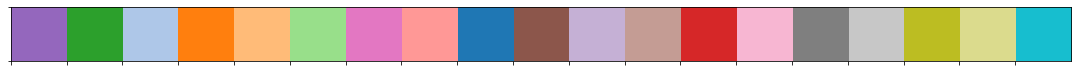

In [153]:
colors = [
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
     (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
     (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
     (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
     (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
     (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
     (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
     (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
     (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
     (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
     (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
     (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
     (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
     (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0),
     (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
     (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
     (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
     (0.8588235294117647, 0.8588235294117647, 0.5529411764705883, 1.0),
     (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)
]
import seaborn as sns
sns.palplot(colors)

(-76.24758052685, -26.590708254149995, -35.70232894755001, 7.222992030549998)

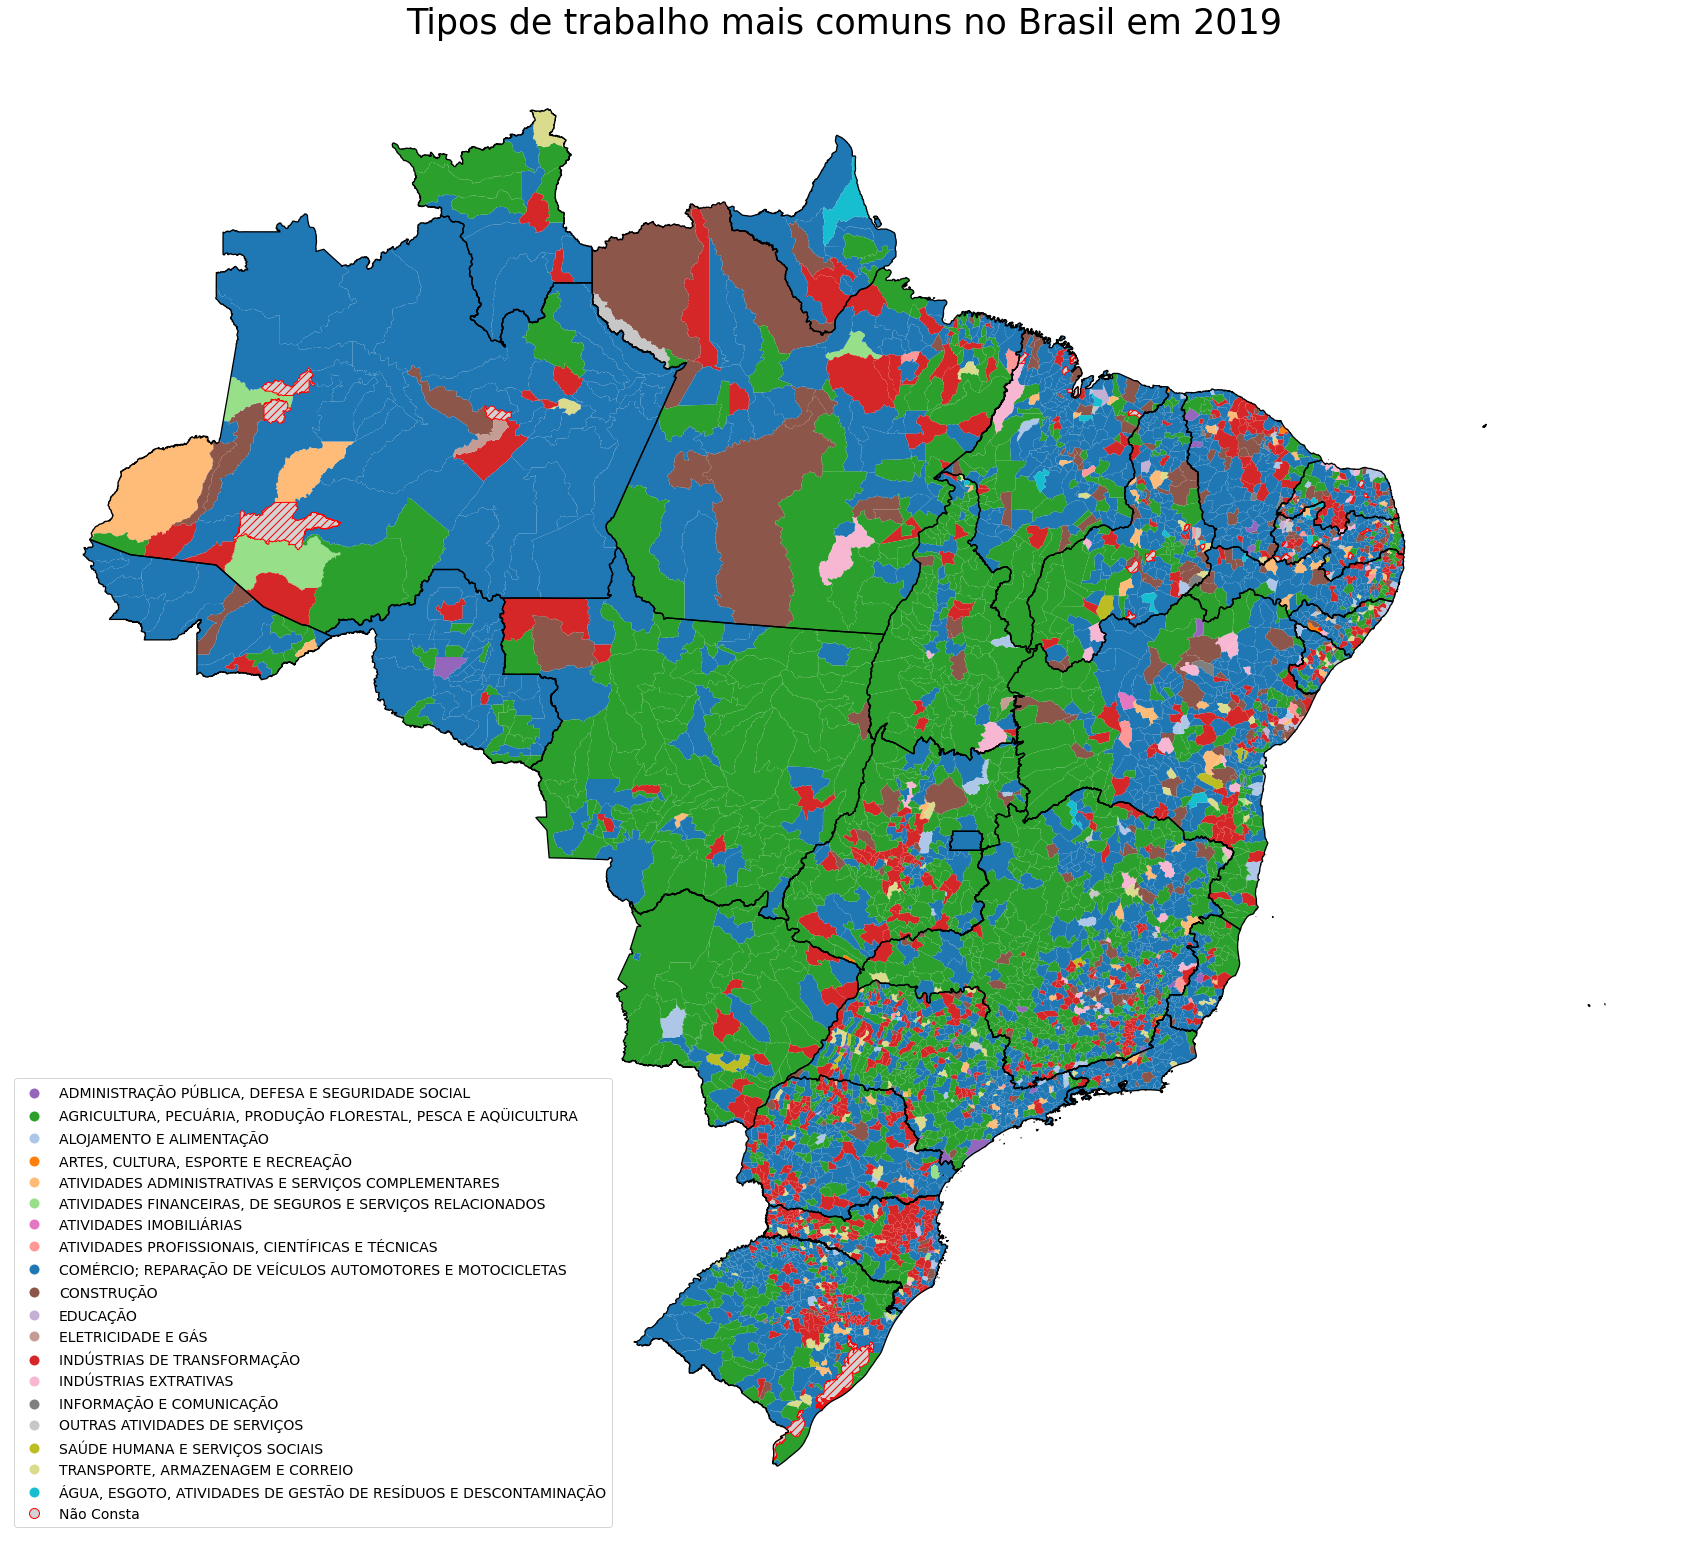

In [154]:
fig = plt.figure(figsize=(30,40))
ax  = fig.add_subplot(1,1,1)
# divider = make_axes_locatable(ax)

ax.set_title('Tipos de trabalho mais comuns no Brasil em 2019', fontsize=35)

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Não Consta",
    }

palette = dict(
    zip(
        df['divisao_economica'].unique(),
        [cm.tab20(x) for x in range(df['divisao_economica'].nunique())]
    )
)

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

legend_kwds = {
    'loc': 'lower left',
    'fontsize':14

}
df.plot(column='divisao_economica',
        categorical=True,
        cmap=cmap,
        ax=ax, 
        legend=True,
        legend_kwds=legend_kwds,
        missing_kwds=missing_kwds
       )

states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax)

ax.axis('off')

# for idx, row in mun_votos.iterrows():
#     plt.annotate(s=str(row['votos']), xy=row['coords'],fontsize=15,
#                  horizontalalignment='center', color='#ffffff')




In [178]:
caged_graph=caged[['ano','divisao_economica']]
caged_graph['count']=1

In [179]:
dd = caged_graph.groupby(['ano','divisao_economica'], as_index=False).sum()
dd = dd.sort_values(by=['ano','count'])


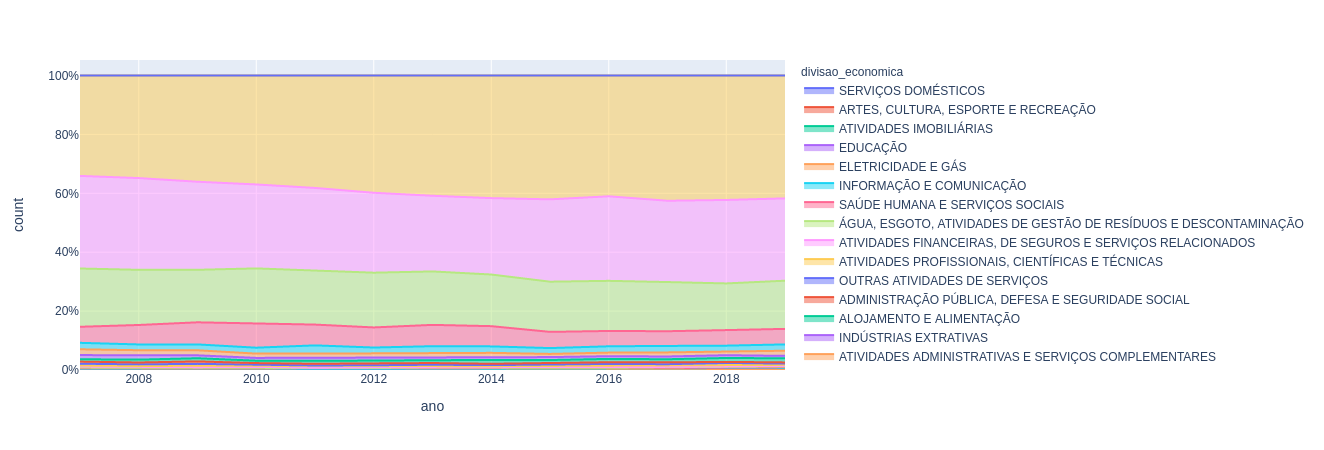

In [180]:
fig = px.area(dd, x="ano", y="count", color="divisao_economica", groupnorm='fraction')
fig.update_layout(yaxis_tickformat='%') 
fig.show()

In [183]:
df_count = df[['divisao_economica']].copy()
df_count['count'] = 1
df_count = df_count.groupby(by='divisao_economica', as_index=False).sum()

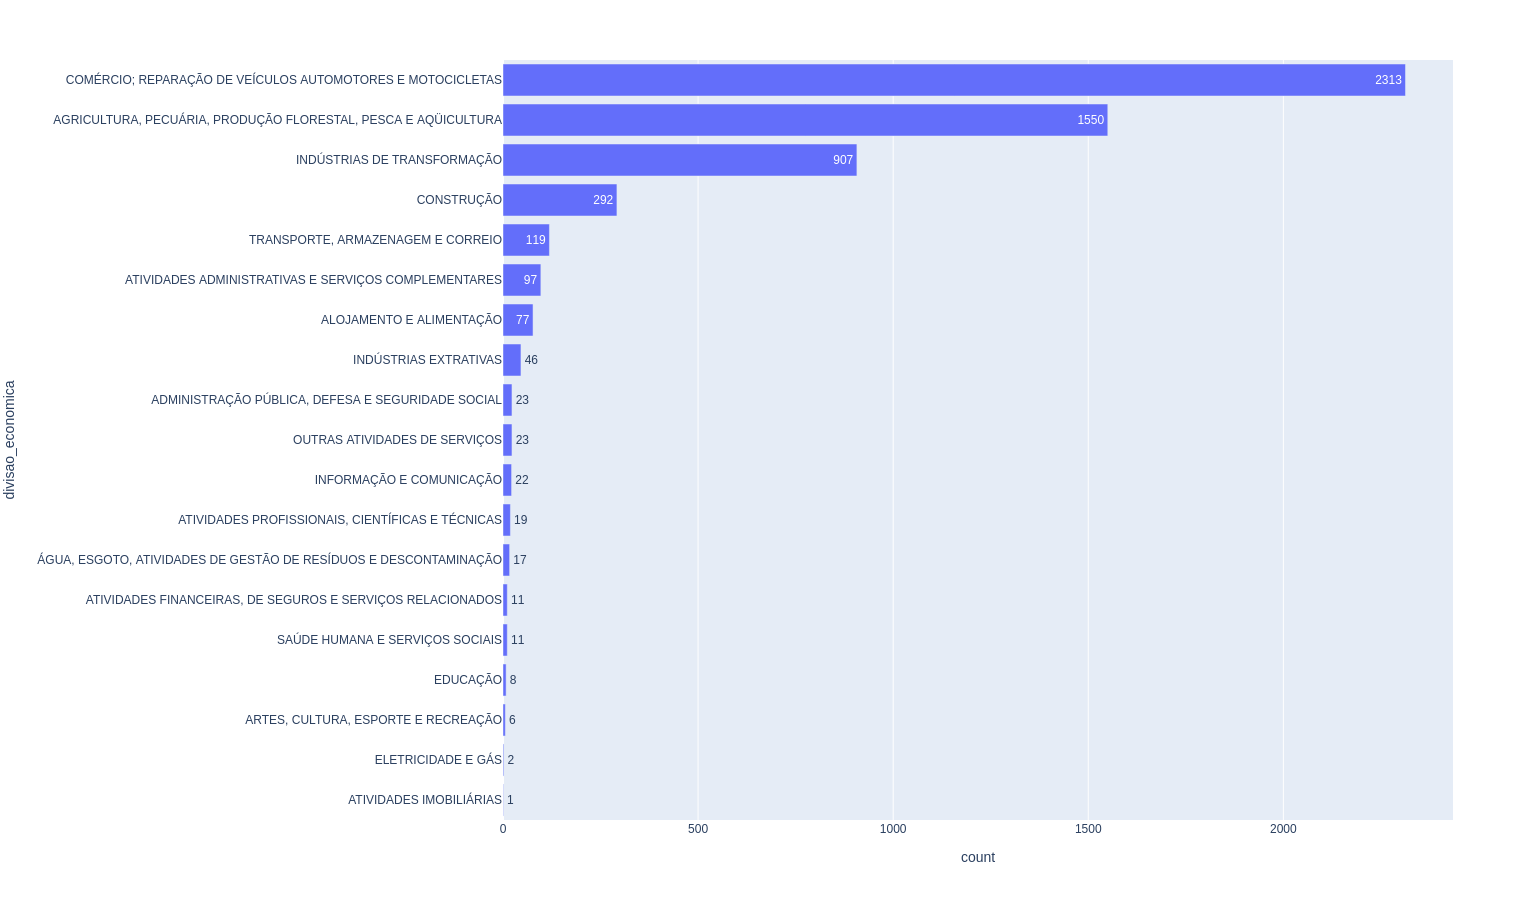

In [191]:
fig = px.bar(df_count.sort_values(by='count'), x="count", y="divisao_economica", text="count")
fig.update_layout(height=900)